In [ ]:
import getpass
import os
from typing import List, Literal, TypedDict
import bs4
from IPython.display import Image, display
from langchain import hub
from langchain.chat_models import init_chat_model
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, create_react_agent, tools_condition
from IPython.display import Image, display
from pydantic import BaseModel, Field
from typing_extensions import List, TypedDict
import warnings

warnings.filterwarnings("ignore")

USER_AGENT environment variable not set, consider setting it to identify your requests.


#### Part -1 : Build a Retrieval Augmented Generation (RAG) App

In [ ]:
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

#### Components

##### Chat model : NVIDIA

In [3]:
if not os.environ.get("NVIDIA_API_KEY"):
    os.environ["NVIDIA_API_KEY"] = getpass.getpass("Enter API key for NVIDIA:")

In [4]:
llm = init_chat_model("meta/llama3-70b-instruct", model_provider="nvidia")

##### Embedding model : NVIDIA

In [5]:
if not os.environ.get("NVIDIA_API_KEY"):
    os.environ["NVIDIA_API_KEY"] = getpass.getpass("Enter API key for NVIDIA: ")

In [6]:
embeddings = NVIDIAEmbeddings(model="NV-Embed-QA")

##### Vector Store : InMemory

In [7]:
vector_store = InMemoryVectorStore(embeddings)

##### RAG chain pipeline with query analysis using langGraph

Total_characters: 43130
Split the blog post into 66 chunks
Total chunks indexed & added to the vector store: 66


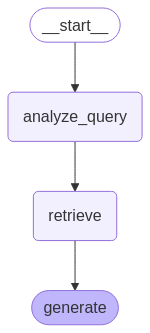

Response: Task decomposition is the process of breaking down a complex task into smaller, simpler steps. This involves transforming big tasks into multiple manageable tasks, making it easier to understand and execute the task. It can be achieved through various methods, including chain of thought, tree of thoughts, and simple prompting techniques.
{'analyze_query': {'query': Search(query='Task Decomposition', section='beginning')}}

----------------

{'retrieve': {'context': [Document(id='a6b51b39-50bd-47ae-a49f-a2fae4c16e3f', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585, 'section': 'beginning'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on compl

In [ ]:
# Load the blog post using WebBaseLoader
bs4_strainer = bs4.SoupStrainer(class_=("post-content", "post-title", "post-header"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()
assert len(docs) == 1
print(f"Total_characters: {len(docs[0].page_content)}")

# Split the blog post into chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)
all_splits = text_splitter.split_documents(docs)
print(f"Split the blog post into {len(all_splits)} chunks")

# Add metadata to each chunk
total_documents = len(all_splits)
third = total_documents // 3

for idx, doc in enumerate(all_splits):
    if idx < third:
        doc.metadata["section"] = "beginning"
    elif idx < third * 2:
        doc.metadata["section"] = "middle"
    else:
        doc.metadata["section"] = "end"

# Add the chunks to the vector store
document_ids = vector_store.add_documents(all_splits)
print("Total chunks indexed & added to the vector store:", len(document_ids))


# Define search schema
class Search(BaseModel):
    query: str = Field(..., description="Search query to run.")
    section: Literal["beginning", "middle", "end"] = Field(
        ..., description="Section to query."
    )  # Field(...) says this is a required field # Literal is a type alias that represents a fixed set of values


# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


# Define analyze_query node
def analyze_query(state: State):

    # Custom prompt for structured query extraction
    system_msg = (
        "You are a helpful assistant that extracts structured data from questions. "
        "Given a user's question, extract the search query and whether the answer should be "
        "from the beginning, middle, or end of a document. "
        "Respond strictly in this JSON format:\n"
        '{ "query": "<search terms>", "section": "beginning|middle|end" }'
    )

    messages = [
        SystemMessage(content=system_msg),
        HumanMessage(content=state["question"]),
    ]

    # Now bind the LLM with only the schema (not a prompt)
    structured_llm = llm.with_structured_output(schema=Search)
    query = structured_llm.invoke(messages)
    return {"query": query}


# Define retrieve node
def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query.query,
        filter=lambda doc: doc.metadata.get("section") == query.section,
    )
    return {"context": retrieved_docs}


# Define generate node
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Build LangGraph
graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

# Run the graph
response = graph.invoke({"question": "What is Task Decomposition?"})
print("Response:", response["answer"])


# Graph stream in steps
for step in graph.stream(
    {"question": "What is Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

##### Other qns and responses

In [10]:
response = graph.invoke({"question": "Who is Lilian Weng?"})
print("Response:", response["answer"])

Response: Lilian Weng is the author of the article about LLM Powered Autonomous Agents.


In [11]:
response = graph.invoke({"question": "Who is the current prime minister of India?"})
print("Response:", response["answer"])

Response: I don't know. The provided context does not mention the current prime minister of India.


In [12]:
response = graph.invoke({"question": "What is LangSmith?"})
print("Response:", response["answer"])

Response: I don't know what LangSmith is, as it is not mentioned in the provided context.


In [13]:
response1 = graph.invoke({"question": "What is Task Decomposition?"})
response2 = graph.invoke({"question": "Where this term is mostly used?"})
print("Response1:", response1["answer"])
print("Response2:", response2["answer"])

Response1: Task decomposition is the process of breaking down a complex task into smaller, simpler steps. This involves transforming big tasks into multiple manageable tasks, making it easier to understand and execute the task. It can be achieved through various methods, including chain of thought, tree of thoughts, and simple prompting.
Response2: The term "generative agent architecture" is mostly used in the context of artificial intelligence and autonomous agents, particularly in reference to AutoGPT and LLM (Large Language Models). It is used to describe a system architecture that enables agents to make decisions independently and pursue simple strategies without legal complications.


* Here, Response 2 is bad because the context memory is not stored so the app fails to talk about the previous context

#### Part -2 : Build a Retrieval Augmented Generation (RAG) App

##### Chains

In [ ]:
os.environ["LANGSMITH_TRACING"] = "true"
if os.environ.get("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

In [ ]:
graph_builder = StateGraph(MessagesState)


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""

    # Perform similarity search and finds the top 2 relevant chunks
    retrieved_docs = vector_store.similarity_search(query, k=2)

    # Converts the retrieved chunks into a string to sent to the LLM
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )

    # Returns: String version of the retrieved content and raw documents
    return serialized, retrieved_docs

In [16]:
# LangGraph Node 1: query_or_respond
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # Appends the response to the overall chat history in the MessagesState
    return {"messages": [response]}


# LangGraph Node 2: ToolNode
# Graph executes this node when LLM decides to call the retrieve tool
tools = ToolNode([retrieve])


# LangGraph Node 3: Generate Node
def generate(state: MessagesState):
    """Generate answer."""

    recent_tool_messages = []

    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break

    tool_messages = recent_tool_messages[::-1]

    # Joins the ToolMessages into a single big context blob

    docs_content = "\n\n".join(doc.content for doc in tool_messages)

    # Build a system message - This acts like a prompt template to the LLM
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )

    # Filters the messages that will be passed to LLM
    conversation_messages = [
        message
        for message in state["messages"]
        if (message.type in ("human", "system"))
        or (message.type == "ai" and not message.tool_calls)
    ]

    # Builds the full prompt for the LLM
    prompt = [SystemMessage(system_message_content)] + conversation_messages
    response = llm.invoke(prompt)

    # APpends the answer to the chat state
    return {"messages": [response]}

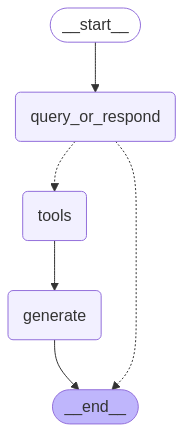

In [17]:
graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point(
    "query_or_respond"
)  # This defines where the message starts.

graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)

graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

# Compiles the graph
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
# Testing - Case 1:

input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()
    print(f"{step}\n\n----------------\n")

================================ Human Message =================================

Hello
{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='81485703-3d14-40ff-9d81-b38c42ff16fa')]}

----------------

================================== Ai Message ==================================

Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?
{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='81485703-3d14-40ff-9d81-b38c42ff16fa'), AIMessage(content="Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'role': 'assistant', 'content': "Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?", 'token_usage': {'prompt_tokens': 11, 'total_tokens': 37, 'completion_tokens': 26}, 'finish_reason': 'stop', 'model_name': 'meta/llama3-70b-instruct'}, id='run

In [19]:
# Testing - Case 2:
input_message = "What is Task Decomposition in short?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()
    print(f"{step}\n\n----------------\n")

================================ Human Message =================================

What is Task Decomposition in short?
{'messages': [HumanMessage(content='What is Task Decomposition in short?', additional_kwargs={}, response_metadata={}, id='c7114bf1-15f7-4e2a-8054-2f1821cd5a74')]}

----------------

================================== Ai Message ==================================

Task Decomposition is a process of breaking down a large, complex task or project into smaller, more manageable and independent sub-tasks or components. This helps to simplify the task, make it easier to understand, and enable easier assignment, execution, and tracking of progress.
{'messages': [HumanMessage(content='What is Task Decomposition in short?', additional_kwargs={}, response_metadata={}, id='c7114bf1-15f7-4e2a-8054-2f1821cd5a74'), AIMessage(content='Task Decomposition is a process of breaking down a large, complex task or project into smaller, more manageable and independent sub-tasks or components

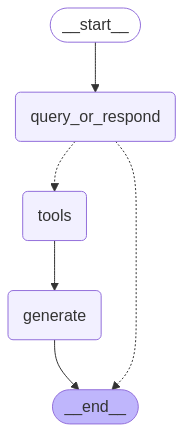

In [20]:
# Memory Saver keeps the past messages in memory
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))
# thread_id is a unique identifier for the thread
config = {"configurable": {"thread_id": "test"}}

In [21]:
# Testing multi-turn memory
input_message = "What is Task Decomposition in short?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition in short?
================================== Ai Message ==================================

Task Decomposition is a process of breaking down a large, complex task or project into smaller, more manageable and independent sub-tasks or components. This helps to simplify the task, make it easier to understand, and enable easier assignment, execution, and tracking of progress.


In [22]:
# Testing with a follow up question
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================

Here are some common ways to perform Task Decomposition:

1. **Top-Down Approach**: Break down a high-level task into smaller sub-tasks, and then further sub-divide those sub-tasks until you reach actionable items.
2. **Divide and Conquer**: Identify the key components of a task and break them down into smaller, independent tasks that can be worked on separately.
3. **Create a Mind Map**: Visualize the task and its components by creating a mind map, which can help identify sub-tasks and relationships between them.
4. **Ask "What needs to be done?"**: Identify the key objectives of the task and ask "What needs to be done?" to break it down into smaller sub-tasks.
5. **Use a Hierarchical Approach**: Break down a task into categories, sub-categories, and eventually, actionable items

#### Agents

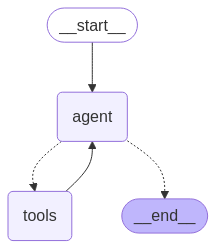

In [23]:
agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [24]:
# Unique ID for this Q&A session (thread)
config = {"configurable": {"thread_id": "test_123"}}

# Give the multi step instruction to the agent
input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent_executor.stream(
    {
        "messages": [{"role": "user", "content": input_message}]
    },  # This is the input to the agent — a single user message. It’s a chat-style format
    stream_mode="values",  #
    config=config,
):
    event["messages"][-1].pretty_print()
    print(f"{event}\n\n----------------\n")

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
{'messages': [HumanMessage(content='What is the standard method for Task Decomposition?\n\nOnce you get the answer, look up common extensions of that method.', additional_kwargs={}, response_metadata={}, id='c50b2591-a193-4819-9393-ce9ec2a42c0e')]}

----------------

================================== Ai Message ==================================

The standard method for Task Decomposition is called **Hierarchical Task Analysis (HTA)**. HTA is a widely used method for breaking down complex tasks into smaller, manageable sub-tasks. It involves identifying the overall goal of the task, and then recursively decomposing it into smaller tasks, sub-tasks, and ultimately, individual actions.

Here's a high-level overview of the HTA process:

1. Identify the overall goal or task
2. Identify the 